In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
import logging

# Set logging level to error to avoid verbose output
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Load the Malaria dataset
dataset, metaset = tfds.load('malaria', as_supervised=True, with_info=True)
train_data = dataset['train']

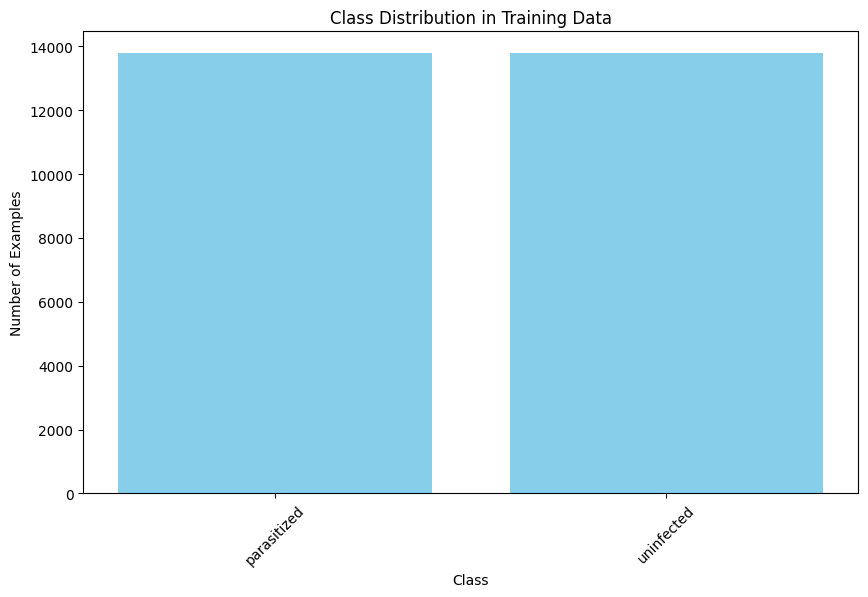

In [ ]:
import matplotlib.pyplot as plt


class_names = metaset.features['label'].names
num_train_examples = metaset.splits['train'].num_examples


class_counts = {}
for class_name in class_names:
    class_counts[class_name] = 0


for image, label in train_data:
    class_counts[class_names[label]] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()


In [ ]:

def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])  # Reduce image size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
  # Normalization in machine learning is a feature scaling technique that transforms the range of features to a standard scale, typically between 0 and 1, to improve model performance and prevent feature dominance.
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random vertical flip
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness adjustment
    return image, label




In [ ]:

train_size =8000
test_size = 1500


train_data_shuffled = train_data.shuffle(num_train_examples)


train_set = train_data.take(train_size)
test_set = train_data.skip(train_size).take(test_size)


train_set = train_set.map(preprocess)


test_set = test_set.map(preprocess)

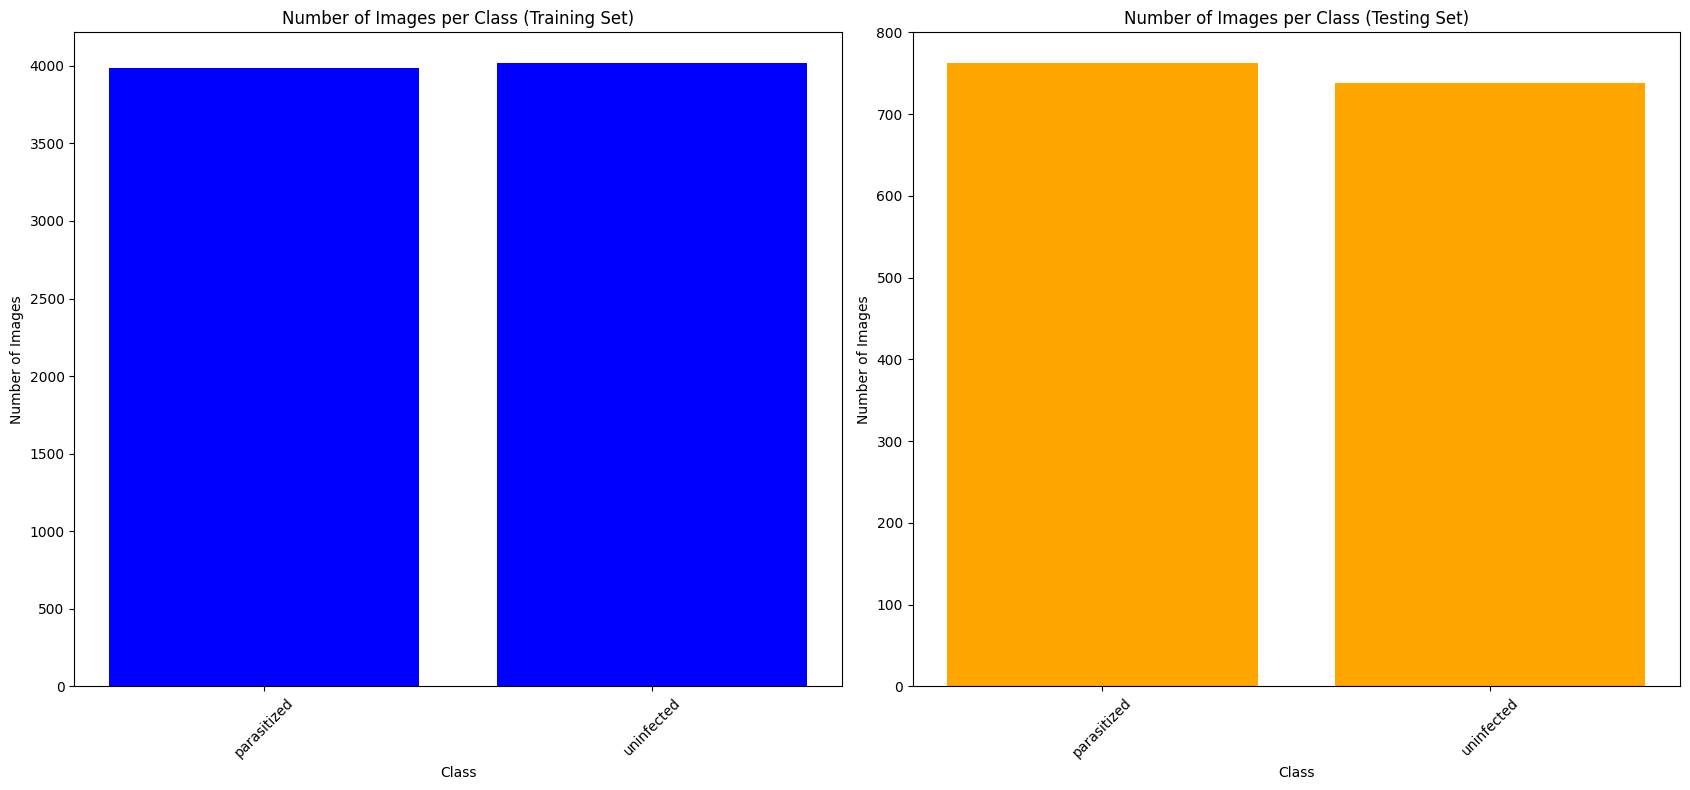

In [ ]:
# Calculating the number of images per class in the training set
train_class_counts = {class_name: 0 for class_name in class_names}
for image, label in train_set:
    # Converting label to scalar integer
    label = int(tf.cast(label, tf.int32).numpy())
    train_class_counts[class_names[label]] += 1

# Calculating  the number of images per class in the testing set
test_class_counts = {class_name: 0 for class_name in class_names}
for image, label in test_set:
    # Converting label to scalar integer
    label = int(tf.cast(label, tf.int32).numpy())
    test_class_counts[class_names[label]] += 1

# Ploting the number of images per class in both training and testing sets
plt.figure(figsize=(17, 8))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Training Set)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class (Testing Set)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Defining batch size
batch_size = 16

# Creating batches of data for training
train_set = train_set.cache().repeat().shuffle(train_size).batch(batch_size)
test_set = test_set.cache().batch(batch_size)



In [ ]:
# Defining the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Calculating steps per epoch
steps_per_epoch = math.ceil(train_size / batch_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# Training the model
history = model.fit(train_set, epochs=10, steps_per_epoch=steps_per_epoch)


Epoch 1/10
500/500 [==============================] - 15s 11ms/step - loss: 0.6733 - accuracy: 0.5845
Epoch 2/10
500/500 [==============================] - 6s 12ms/step - loss: 0.6487 - accuracy: 0.6271
Epoch 3/10
500/500 [==============================] - 6s 11ms/step - loss: 0.3563 - accuracy: 0.8776
Epoch 4/10
500/500 [==============================] - 6s 11ms/step - loss: 0.1614 - accuracy: 0.9465
Epoch 5/10
500/500 [==============================] - 5s 11ms/step - loss: 0.1554 - accuracy: 0.9507
Epoch 6/10
500/500 [==============================] - 6s 11ms/step - loss: 0.1350 - accuracy: 0.9556
Epoch 7/10
500/500 [==============================] - 6s 12ms/step - loss: 0.1209 - accuracy: 0.9600
Epoch 8/10
500/500 [==============================] - 6s 11ms/step - loss: 0.1116 - accuracy: 0.9615
Epoch 9/10
500/500 [==============================] - 5s 11ms/step - loss: 0.0968 - accuracy: 0.9678
Epoch 10/10
500/500 [==============================] - 5s 11ms/step - loss: 0.0881 - accur

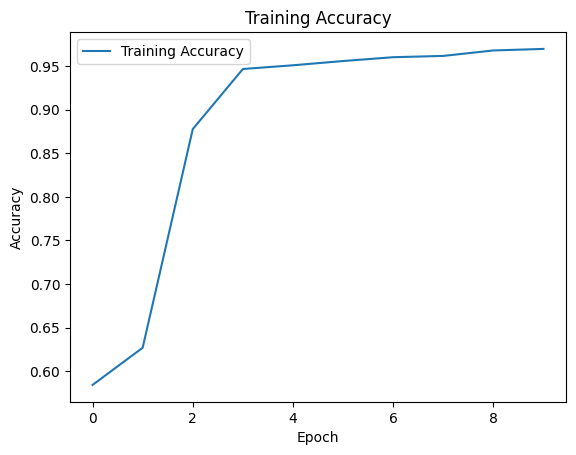

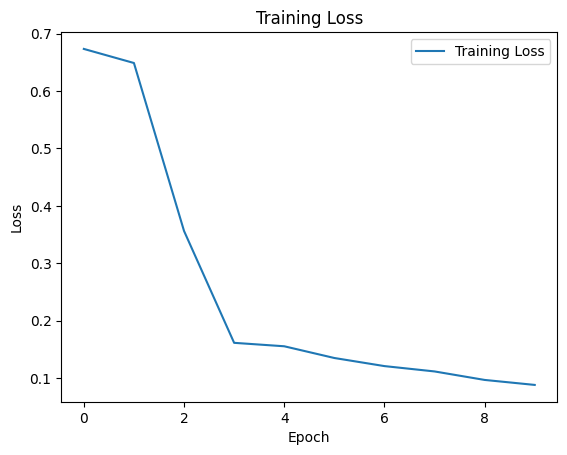

In [ ]:
# Ploting training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Ploting training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


94/94 [==============================] - 1s 6ms/step - loss: 0.1827 - accuracy: 0.9593
Test Loss: 0.18272043764591217
Test Accuracy: 0.9593333601951599


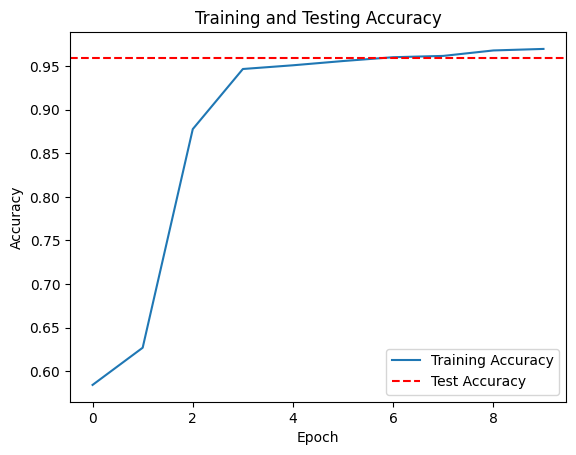

In [ ]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plotting training and testing accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 19ms/step
Predicted class: parasitized


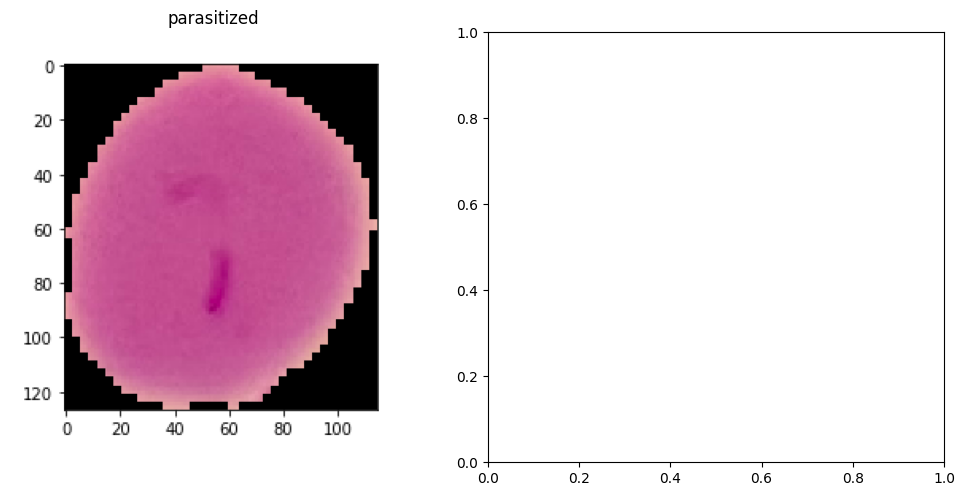

In [ ]:
from PIL import Image as pic
import os
import numpy as np
import math
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained model
# model = tf.keras.models.load_model('path_to_your_saved_model')

image_url = "https://user-images.githubusercontent.com/35381035/73947022-d7673a80-491c-11ea-9906-21c39ff33751.png"
response = requests.get(image_url)

image1 = pic.open(BytesIO(response.content)).convert("RGB")  # Convert image to RGB format
image2 = image1.resize((128, 128))
image_array = tf.keras.preprocessing.image.img_to_array(image2)
image_cast = image_array / 255.0
image_for_model = tf.expand_dims(image_cast, axis=0)

# Make prediction
prediction = model.predict(image_for_model)
predicted_class_index = np.argmax(prediction)

# Map class index to class name
class_names = ['parasitized', 'uninfected']
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")

# Display the image and prediction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the tested image on a 250 by 250 pixel canvas
ax[0].imshow(image1)
ax[0].set_title(predicted_class_name)
ax[0].axis('off')


plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 20ms/step
Predicted class: uninfected


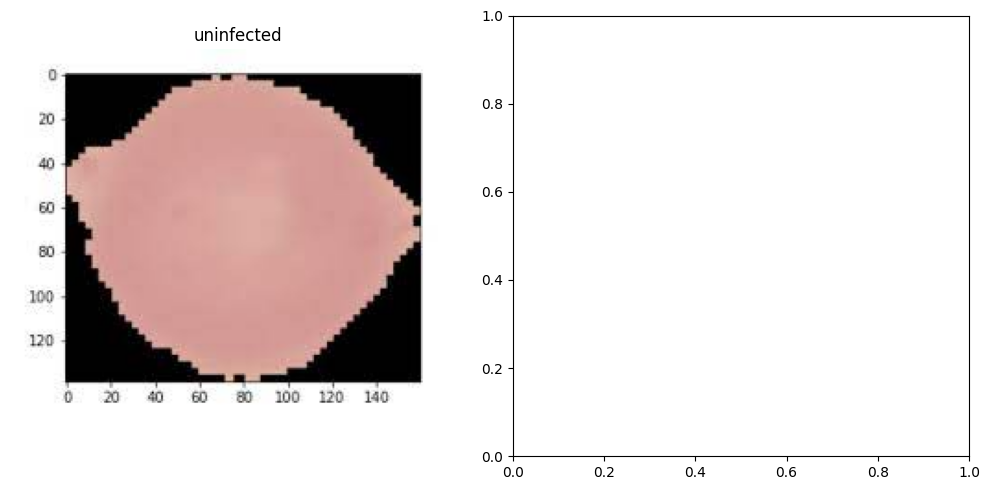

In [ ]:
from PIL import Image as pic
import os
import numpy as np
import math
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained model
# model = tf.keras.models.load_model('path_to_your_saved_model')

image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSIWEWlU59P_1fXh25DQoJ9j8Lz96c778J0MxgDXMaNp6Rcd1a4hCz5LvznCjZtF3AOiKM&usqp=CAU"
response = requests.get(image_url)

image1 = pic.open(BytesIO(response.content)).convert("RGB")  # Convert image to RGB format
image2 = image1.resize((128, 128))
image_array = tf.keras.preprocessing.image.img_to_array(image2)
image_cast = image_array / 255.0
image_for_model = tf.expand_dims(image_cast, axis=0)

# Make prediction
prediction = model.predict(image_for_model)
predicted_class_index = np.argmax(prediction)

# Map class index to class name
class_names = ['parasitized', 'uninfected']
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")

# Display the image and prediction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the tested image on a 250 by 250 pixel canvas
ax[0].imshow(image1)
ax[0].set_title(predicted_class_name)
ax[0].axis('off')


plt.tight_layout()
plt.show()
